In [1]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow import keras,lite


For better data visualization we'll use [Pandas library](https://pandas.pydata.org/).

In [3]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [4]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.6.0
Hub version:  0.12.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is NOT AVAILABLE


2021-11-28 18:00:56.218085: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset preparation

 For this example you will use the TensorFlow flowers dataset.

In [5]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [6]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [7]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [8]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


In [9]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax'),
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [11]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/20


2021-11-28 18:00:58.099575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 1/92 [..............................] - ETA: 4:06 - loss: 2.1428 - acc: 0.1875

 2/92 [..............................] - ETA: 21s - loss: 2.0602 - acc: 0.1719 

 3/92 [..............................] - ETA: 21s - loss: 2.0332 - acc: 0.1667

 4/92 [>.............................] - ETA: 21s - loss: 1.9632 - acc: 0.2188

 5/92 [>.............................] - ETA: 21s - loss: 1.9428 - acc: 0.2313

 6/92 [>.............................] - ETA: 20s - loss: 1.8974 - acc: 0.2448

 7/92 [=>............................] - ETA: 20s - loss: 1.8659 - acc: 0.2589

 8/92 [=>............................] - ETA: 20s - loss: 1.8316 - acc: 0.2734

 9/92 [=>............................] - ETA: 20s - loss: 1.7896 - acc: 0.2812

10/92 [==>...........................] - ETA: 19s - loss: 1.7776 - acc: 0.2844

11/92 [==>...........................] - ETA: 19s - loss: 1.7550 - acc: 0.2955

12/92 [==>...........................] - ETA: 19s - loss: 1.7104 - acc: 0.3073

13/92 [===>..........................] - ETA: 19s - loss: 1.6784 - acc: 0.3101

14/92 [===>..........................] - ETA: 19s - loss: 1.6503 - acc: 0.3192

15/92 [===>..........................] - ETA: 18s - loss: 1.6242 - acc: 0.3271

16/92 [====>.........................] - ETA: 18s - loss: 1.6067 - acc: 0.3320

17/92 [====>.........................] - ETA: 18s - loss: 1.5866 - acc: 0.3419

18/92 [====>.........................] - ETA: 18s - loss: 1.5872 - acc: 0.3368

19/92 [=====>........................] - ETA: 17s - loss: 1.5532 - acc: 0.3586

20/92 [=====>........................] - ETA: 17s - loss: 1.5197 - acc: 0.3781

21/92 [=====>........................] - ETA: 17s - loss: 1.4789 - acc: 0.4018

22/92 [======>.......................] - ETA: 17s - loss: 1.4707 - acc: 0.4034

23/92 [======>.......................] - ETA: 16s - loss: 1.4515 - acc: 0.4103

24/92 [======>.......................] - ETA: 16s - loss: 1.4305 - acc: 0.4206

25/92 [=======>......................] - ETA: 16s - loss: 1.4068 - acc: 0.4325

26/92 [=======>......................] - ETA: 16s - loss: 1.3883 - acc: 0.4399

27/92 [=======>......................] - ETA: 16s - loss: 1.3715 - acc: 0.4444

28/92 [========>.....................] - ETA: 15s - loss: 1.3485 - acc: 0.4565

29/92 [========>.....................] - ETA: 15s - loss: 1.3387 - acc: 0.4612

30/92 [========>.....................] - ETA: 15s - loss: 1.3206 - acc: 0.4667

31/92 [=========>....................] - ETA: 15s - loss: 1.3068 - acc: 0.4728

32/92 [=========>....................] - ETA: 14s - loss: 1.2862 - acc: 0.4834

33/92 [=========>....................] - ETA: 14s - loss: 1.2765 - acc: 0.4848

34/92 [==========>...................] - ETA: 14s - loss: 1.2607 - acc: 0.4936

35/92 [==========>...................] - ETA: 14s - loss: 1.2401 - acc: 0.5045

36/92 [==========>...................] - ETA: 13s - loss: 1.2253 - acc: 0.5104

37/92 [===========>..................] - ETA: 13s - loss: 1.2124 - acc: 0.5169

38/92 [===========>..................] - ETA: 13s - loss: 1.1969 - acc: 0.5222

39/92 [===========>..................] - ETA: 13s - loss: 1.1820 - acc: 0.5296

40/92 [============>.................] - ETA: 12s - loss: 1.1764 - acc: 0.5328

41/92 [============>.................] - ETA: 12s - loss: 1.1631 - acc: 0.5381

42/92 [============>.................] - ETA: 12s - loss: 1.1558 - acc: 0.5402

43/92 [=============>................] - ETA: 12s - loss: 1.1467 - acc: 0.5436

44/92 [=============>................] - ETA: 11s - loss: 1.1427 - acc: 0.5462

45/92 [=============>................] - ETA: 11s - loss: 1.1383 - acc: 0.5472

46/92 [==============>...............] - ETA: 11s - loss: 1.1329 - acc: 0.5489

47/92 [==============>...............] - ETA: 11s - loss: 1.1227 - acc: 0.5532

48/92 [==============>...............] - ETA: 10s - loss: 1.1144 - acc: 0.5579

49/92 [==============>...............] - ETA: 10s - loss: 1.1066 - acc: 0.5606

50/92 [===============>..............] - ETA: 10s - loss: 1.0957 - acc: 0.5650

51/92 [===============>..............] - ETA: 10s - loss: 1.0895 - acc: 0.5679

52/92 [===============>..............] - ETA: 9s - loss: 1.0787 - acc: 0.5726 

53/92 [================>.............] - ETA: 9s - loss: 1.0744 - acc: 0.5736

54/92 [================>.............] - ETA: 9s - loss: 1.0612 - acc: 0.5792

55/92 [================>.............] - ETA: 9s - loss: 1.0584 - acc: 0.5812

56/92 [=================>............] - ETA: 8s - loss: 1.0487 - acc: 0.5859

57/92 [=================>............] - ETA: 8s - loss: 1.0396 - acc: 0.5882

58/92 [=================>............] - ETA: 8s - loss: 1.0310 - acc: 0.5921

59/92 [==================>...........] - ETA: 8s - loss: 1.0268 - acc: 0.5943

60/92 [==================>...........] - ETA: 7s - loss: 1.0187 - acc: 0.5990

61/92 [==================>...........] - ETA: 7s - loss: 1.0075 - acc: 0.6045

62/92 [===================>..........] - ETA: 7s - loss: 1.0026 - acc: 0.6059

63/92 [===================>..........] - ETA: 7s - loss: 0.9976 - acc: 0.6082

64/92 [===================>..........] - ETA: 6s - loss: 0.9908 - acc: 0.6109

65/92 [====================>.........] - ETA: 6s - loss: 0.9822 - acc: 0.6149

66/92 [====================>.........] - ETA: 6s - loss: 0.9752 - acc: 0.6175

67/92 [====================>.........] - ETA: 6s - loss: 0.9680 - acc: 0.6213

68/92 [=====================>........] - ETA: 5s - loss: 0.9604 - acc: 0.6237

69/92 [=====================>........] - ETA: 5s - loss: 0.9562 - acc: 0.6260

70/92 [=====================>........] - ETA: 5s - loss: 0.9492 - acc: 0.6295

71/92 [======================>.......] - ETA: 5s - loss: 0.9398 - acc: 0.6334

72/92 [======================>.......] - ETA: 4s - loss: 0.9319 - acc: 0.6377

73/92 [======================>.......] - ETA: 4s - loss: 0.9258 - acc: 0.6405

74/92 [=======================>......] - ETA: 4s - loss: 0.9229 - acc: 0.6424

75/92 [=======================>......] - ETA: 4s - loss: 0.9181 - acc: 0.6455

76/92 [=======================>......] - ETA: 3s - loss: 0.9153 - acc: 0.6469

77/92 [========================>.....] - ETA: 3s - loss: 0.9117 - acc: 0.6482

78/92 [========================>.....] - ETA: 3s - loss: 0.9081 - acc: 0.6503

79/92 [========================>.....] - ETA: 3s - loss: 0.9053 - acc: 0.6520

80/92 [=========================>....] - ETA: 2s - loss: 0.9001 - acc: 0.6540

81/92 [=========================>....] - ETA: 2s - loss: 0.8971 - acc: 0.6552

82/92 [=========================>....] - ETA: 2s - loss: 0.8922 - acc: 0.6586

83/92 [==========================>...] - ETA: 2s - loss: 0.8854 - acc: 0.6620

84/92 [==========================>...] - ETA: 1s - loss: 0.8805 - acc: 0.6653

85/92 [==========================>...] - ETA: 1s - loss: 0.8746 - acc: 0.6670

86/92 [===========================>..] - ETA: 1s - loss: 0.8706 - acc: 0.6680

87/92 [===========================>..] - ETA: 1s - loss: 0.8677 - acc: 0.6689

88/92 [===========================>..] - ETA: 0s - loss: 0.8641 - acc: 0.6702

89/92 [============================>.] - ETA: 0s - loss: 0.8597 - acc: 0.6711

90/92 [============================>.] - ETA: 0s - loss: 0.8555 - acc: 0.6730

91/92 [============================>.] - ETA: 0s - loss: 0.8516 - acc: 0.6753

92/92 [==============================] - ETA: 0s - loss: 0.8493 - acc: 0.6764

KeyboardInterrupt: 

In [ ]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

23/23 [==============================] - 37s 2s/step - loss: 0.3436 - acc: 0.8960


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.33
Final accuracy: 87.14%


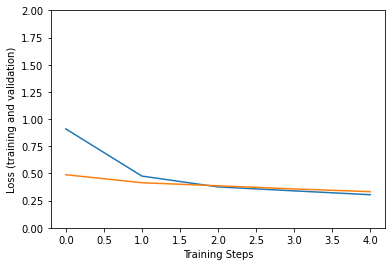

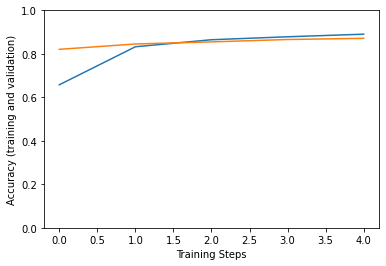

In [ ]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

### Export your model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.

In [ ]:
# FLOWERS_SAVED_MODEL = "flowers.h5"
# tf.saved_model.save(model, FLOWERS_SAVED_MODEL)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tfmodel)